# Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir("/home/luca/Scrivania/autospectralization")

In [37]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use("nbAgg")
%matplotlib inline

In [6]:
import time

import tensorflow as tf

# Don't allocate all the gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import torch
torch.set_printoptions(precision=15)

from src.plotter import *

In [7]:
import matplotlib
import matplotlib.pyplot as plt

from itertools import cycle

matplotlib.use("nbAgg")
%matplotlib inline 


import wraplot

plot = wraplot.PlotCoupledBarsComparison()
subplotter = wraplot.Subplotter()


# Config

In [8]:
device = 'cuda'
precision = 'double'

In [9]:
info = {}
def get_name(framework, name, direction, precision):
    return f'{framework}_upto_{name}_{direction}time_{precision}'

def print_bench_stat(framework, total_time, forward_time, backward_time, grad, precision, name=None, info=None, verbose=True):
    if info is not None:
        for x, y in [('total', total_time), ('forward', forward_time), ('backward', backward_time)]:
            key = get_name(framework, name, x, precision)
            info[key] = y
    
    if verbose:
        print(f'Benchmark [{framework}] [{precision}] { f"[up to: {name}]" if name else ""}')
        print(f'\tTotal elapsed time: {total_time:.4f} seconds')
        print(f'\t\tForward elapsed time: {forward_time:.4f} seconds')
        print(f'\t\tBackward elapsed time: {backward_time:.4f} seconds')
        print()
        print(f'\tGradients:')
        print("\t\t" + str(grad).replace('\n','\n\t\t'))
        print()
    return info
          
def benchmark_torch(function, function_inputs, precision, title, info=None, verbose=True):
    start_forward = time.time()
    out = function(*function_inputs)
    torch.cuda.synchronize()
    end_forward = time.time()
    
    start_backward = time.time()
    out.backward()
    torch.cuda.synchronize()
    end_backward = time.time()
          
    total_time = end_backward - start_forward
    forward_time = end_forward - start_forward
    backward_time = end_backward - start_backward
          
    info = print_bench_stat('PyTorch', 
                     total_time, 
                     forward_time, 
                     backward_time,
                     function_inputs[0].grad,
                     precision,
                     title,
                     info,
                    verbose)
          
    return info, function_inputs[0].grad
           
def benchmark_tf(function, function_inputs, precision, title, info=None, verbose=True):
    main_input = function_inputs[0]
    
    with tf.GradientTape() as gen_tape:
        gen_tape.watch(main_input)
        start_forward = time.time()
        out = function(*function_inputs)
        end_forward = time.time()
    
    start_backward = time.time()
    gradients_gen = gen_tape.gradient(out, main_input)
    end_backward = time.time()
      
    grad = tf.convert_to_tensor(gradients_gen)
          
    total_time = end_backward - start_forward
    forward_time = end_forward - start_forward
    backward_time = end_backward - start_backward

    info = print_bench_stat('TensorFlow',
                 total_time, 
                 forward_time, 
                 backward_time,
                 grad,
                 precision,
                 title,
                 info,
                verbose)
 
    return info, grad

def allclose(a, b, name=""):
    a = np.asarray(a)
    b = np.asarray(b)
    print(f'Equality check {name}:\t{np.allclose(a, b)}\t  ' +\
          f'\n\tErrore assoluto: max(abs( torch - tf )) = {np.max(np.abs(a - b))}; ' +\
          f'\n\tErrore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = {np.max(np.abs( (a - b) / np.maximum(np.abs(a), 1e-10) ) )  }')
              

def display_benchmark(obj, name, ylim=.25):
    subplotter = wraplot.Subplotter(figsize=(15, 7))
    float_perf = plot.Object(
        bar1_values=[
            obj[get_name('PyTorch', name, 'total', 'float')],
            obj[get_name('PyTorch', name, 'forward', 'float')],
            obj[get_name('PyTorch', name, 'backward', 'float')],
        ],
        bar2_values=[
            obj[get_name('TensorFlow', name, 'total', 'float')],
            obj[get_name('TensorFlow', name, 'forward', 'float')],
            obj[get_name('TensorFlow', name, 'backward', 'float')],
        ],
        label1 = 'PyTorch',
        label2 = 'TensorFlow',
        ylabel = 'Seconds',
        xticklabels=['Total', 'Forward', 'Backward'], 
        title=name.capitalize(), 
        subtitle='float',
        titlesize=40,
        ylim=(0, ylim)
    )
    double_perf = plot.Object(
        bar1_values=[
            obj[get_name('PyTorch', name, 'total', 'double')],
            obj[get_name('PyTorch', name, 'forward', 'double')],
            obj[get_name('PyTorch', name, 'backward', 'double')],
        ],
        bar2_values=[
            obj[get_name('TensorFlow', name, 'total', 'double')],
            obj[get_name('TensorFlow', name, 'forward', 'double')],
            obj[get_name('TensorFlow', name, 'backward', 'double')],
        ],
        label1 = 'PyTorch',
        label2 = 'TensorFlow',
        ylabel = 'Seconds',
        xticklabels=['Total', 'Forward', 'Backward'], 
        title=name.capitalize(), 
        subtitle='double',
        titlesize=20,
        ylim=(0, ylim)
    )
    return subplotter([float_perf, double_perf], plot_functions=plot, subplotadjust=0.9)

# Load mesh

All the test are performed on the **mesh of a face**, from the COMA dataset, with:

- 3931 vertices
- 7800 faces

In [10]:
import hdf5storage

data = hdf5storage.loadmat('./coma_FEM.mat')
pix = data['meshes_noeye'].reshape(data['meshes_noeye'].shape[0], data['meshes_noeye'].shape[1], 3).astype('float32') # Vertices of the meshes

In [11]:
faces = data['f_noeye'] - 1 # important!
vertices =  pix[0, :, :]

print(f'Mesh loaded.\n' + \
      f'\tNum. vertices: {vertices.shape[0]}\n' + \
      f'\tNum. faces: {faces.shape[0]}')

Mesh loaded.
	Num. vertices: 3931
	Num. faces: 7800


# Build tensors

## Build PyTorch tensors

In [10]:
def get_pytorch_tensors(precision=precision):
    vertices_torch = torch.as_tensor(vertices, 
                                     device=device,
                                     dtype=torch.double if precision == 'double' else torch.float).clone().detach().requires_grad_(True)
    faces_torch = torch.as_tensor(faces.astype(np.int64), device=device, dtype=torch.int64)
    return vertices_torch, faces_torch 

## Build TensorFlow tensors

In [11]:
def get_tensorflow_tensors(precision=precision):
    vertices_tf = tf.convert_to_tensor(vertices, dtype = tf.float64 if precision == 'double' else tf.float32)
    faces_tf = tf.convert_to_tensor(faces, dtype=tf.int64)
    return vertices_tf, faces_tf

# Linear Finite Element Assembly 

**Porting of calc_LB_FEM.m** in PyTorch and TensorFlow.
- The assembly is performed using the cotan method, proved to be equivalent to Linear FEM.
- The **lumped mass matrix is represented as a dense vector**, the diagonal of the lumped mass matrix.

## Implementation

- The cotan method **does not require fancy indexing**, thus it is possible to perform the assembly using only sparse tensors.
- The float precision introduces an error in the computations, that is comulated when performing the assembly. **The approximation error is different** w.r.t PyTorch and TensorFlow

### PyTorch Implementation

*Known limitations*

- 



In [30]:
def calc_tri_areas_torch(vertices, faces):
    v1 = vertices[faces[:, 0], :]
    v2 = vertices[faces[:, 1], :]
    v3 = vertices[faces[:, 2], :]
    
    v1 = v1 - v3
    v2 = v2 - v3
    return torch.norm(torch.cross(v1, v2, dim=1), dim=1) * .5

def calc_LB_FEM_torch(vertices, faces, device='cuda'):
    n = vertices.shape[0]
    m = faces.shape[0]
    
    angles = {}
    for i in (1.0, 2.0, 3.0):
        a = torch.fmod(torch.as_tensor(i - 1), torch.as_tensor(3.)).long()
        b = torch.fmod(torch.as_tensor(i), torch.as_tensor(3.)).long()
        c = torch.fmod(torch.as_tensor(i + 1), torch.as_tensor(3.)).long()

        ab = vertices[faces[:,b],:] - vertices[faces[:,a],:];
        ac = vertices[faces[:,c],:] - vertices[faces[:,a],:];

        ab = torch.nn.functional.normalize(ab, p=2, dim=1)
        ac = torch.nn.functional.normalize(ac, p=2, dim=1)
        
        o = torch.mul(ab, ac)
        o = torch.sum(o, dim=1)
        o = torch.acos(o)
        o = torch.div(torch.cos(o), torch.sin(o))
        
        angles[i] = o
    
    indicesI = torch.cat((faces[:, 0], faces[:, 1], faces[:, 2], faces[:, 2], faces[:, 1], faces[:, 0]))
    indicesJ = torch.cat((faces[:, 1], faces[:, 2], faces[:, 0], faces[:, 1], faces[:, 0], faces[:, 2]))
    indices = torch.stack((indicesI, indicesJ))
    
    one_to_n = torch.arange(0, n, dtype=torch.long, device=device)
    eye_indices = torch.stack((one_to_n, one_to_n))

    values = torch.cat((angles[3], angles[1], angles[2], angles[1], angles[3], angles[2])) * 0.5

    
    stiff = torch.sparse_coo_tensor(indices=indices, dtype=values.dtype,
                                 values=-values,
                                 device=device,
                                 size=(n, n)).coalesce()
    stiff = stiff + torch.sparse_coo_tensor(indices=eye_indices, dtype=values.dtype,
                                 values=-torch.sparse.sum(stiff, dim=0).to_dense(),
                                 device=device,
                                 size=(n, n)).coalesce()
    
    areas = calc_tri_areas_torch(vertices, faces)
    areas = areas.repeat(6) / 12.
    
    mass = torch.sparse_coo_tensor(indices=indices, dtype=values.dtype,
                             values=areas,
                             device=device,
                             size=(n, n)).coalesce()
    mass = mass + torch.sparse_coo_tensor(indices=eye_indices, dtype=values.dtype,
                                 values=torch.sparse.sum(mass, dim=0).to_dense(),
                                 device=device,
                                 size=(n, n)).coalesce()
    
    lumped_mass = torch.sparse.sum(mass, dim=1).to_dense()
    return stiff, mass, lumped_mass

### Tensorflow Implementation

*Known limitations*:

- Repeated indices in sparse assembly are ignored, only the last one is taken. It is necessary to manually sum repeated indices reproducing the behaviour of matlab, scipy or pytorch.

In [31]:
def build_sparse_tensor(indices, values, n):
    # -> Emulate sum of duplicated indices
    # https://stackoverflow.com/questions/38233821/merge-duplicate-indices-in-a-sparse-tensor
    
    linearized = tf.matmul(indices, tf.constant([[n], [1]], dtype=tf.int64))
    y, idx = tf.unique(tf.squeeze(linearized))
    values = tf.math.unsorted_segment_sum(values, idx, num_segments=y.shape[0])
    y = tf.expand_dims(y, 1)
    indices = tf.concat([y//n, y%n], axis=1)
    return tf.sparse.reorder(tf.SparseTensor(indices=indices, values=values, dense_shape=[n, n]))

In [32]:
def calc_tri_areas_tf(VERT, TRIV):
    V1 = tf.gather(VERT, TRIV[:, 0])
    V2 = tf.gather(VERT, TRIV[:, 1])
    V3 = tf.gather(VERT, TRIV[:, 2])

    V1 = V1 - V3
    V2 = V2 - V3
    return tf.norm(tf.linalg.cross(V1, V2),axis=1) * 0.5


def calc_LB_FEM_tf(VERT, TRIV):
    n = VERT.shape[0]
    m = TRIV.shape[0]

    angles = {}
    for i in (1.0, 2.0, 3.0):
        a = tf.cast(tf.math.mod(i - 1, 3), tf.int64)
        b = tf.cast(tf.math.mod(i, 3), tf.int64)
        c = tf.cast(tf.math.mod(i + 1, 3), tf.int64)

        a_indexing = tf.gather(VERT, TRIV[:, a])
        ab = tf.gather(VERT, TRIV[:, b]) - a_indexing
        ac = tf.gather(VERT, TRIV[:, c]) - a_indexing

        ab = tf.math.l2_normalize(ab, axis=1)
        ac = tf.math.l2_normalize(ac, axis=1)

        o =  tf.acos(tf.reduce_sum(tf.multiply(ab, ac),axis=1))
        o = tf.divide(tf.math.cos(o), tf.math.sin(o))
        angles[i] = o

    
    indicesI = tf.concat((TRIV[:,0], TRIV[:,1], TRIV[:,2], TRIV[:,2], TRIV[:,1], TRIV[:,0]), axis=0)
    indicesJ = tf.concat((TRIV[:,1], TRIV[:,2], TRIV[:,0], TRIV[:,1], TRIV[:,0], TRIV[:,2]), axis=0)
    indices = tf.stack((indicesI, indicesJ), axis=1)

    values = tf.concat((angles[3], angles[1], angles[2], angles[1], angles[3], angles[2]), axis=0) * 0.5

    one_to_n = tf.range(0, n, dtype=tf.int64)
    eye_indices = tf.stack((one_to_n, one_to_n), axis=1)

    W = build_sparse_tensor(indices, -values, n)
    W = tf.sparse.add(W, 
                      tf.SparseTensor(indices=eye_indices, 
                                      values = - tf.sparse.reduce_sum(W, axis=0), 
                                      dense_shape=[n, n]))

    areas = calc_tri_areas_tf(VERT, TRIV)

    values = tf.tile(areas, [6]) / 12
    Sc = build_sparse_tensor(indices, values, n)
    Sc = tf.sparse.add(Sc, 
                       tf.SparseTensor(indices=eye_indices,
                                       values= tf.sparse.reduce_sum(Sc, axis=0),
                                       dense_shape=[n, n]))

    Sl =  tf.sparse.reduce_sum(Sc, axis=1)
    stiffness = W
    mass = Sc
    lumped_mass = Sl
    return stiffness, mass, lumped_mass

## Coherency

Ensure the PyTorch and TensorFlow computation in the forward pass are coherent.

In [33]:
def check_coherency(precision):

    xtorch, ytorch = get_pytorch_tensors(precision)
    xtf, ytf = get_tensorflow_tensors(precision)

    areastorch = calc_tri_areas_torch(xtorch, ytorch)
    areastf = calc_tri_areas_tf(xtf, ytf)

    atorch, btorch, ctorch = calc_LB_FEM_torch(xtorch, ytorch)
    atf, btf, ctf = calc_LB_FEM_tf(xtf, ytf)
    
    allclose(areastorch.cpu().detach(), areastf, 'areas' )
    allclose(atorch.cpu().detach().to_dense(), tf.sparse.to_dense(atf), 'stiff' )
    allclose(btorch.cpu().detach().to_dense(), tf.sparse.to_dense(btf), 'mass' )
    allclose(ctorch.cpu().detach(), ctf, 'lumped' )

### Float precision

In [34]:
check_coherency('float')

Equality check areas:	True	  
	Errore assoluto: max(abs( torch - tf )) = 2.9103830456733704e-11; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 2.3811247729099705e-07
Equality check stiff:	False	  
	Errore assoluto: max(abs( torch - tf )) = 1.1729736328125; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 0.0037514904979616404
Equality check mass:	True	  
	Errore assoluto: max(abs( torch - tf )) = 4.3655745685100555e-11; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 3.2872108590709104e-07
Equality check lumped:	True	  
	Errore assoluto: max(abs( torch - tf )) = 1.1641532182693481e-10; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 3.2872108590709104e-07


### Double precision

In [35]:
check_coherency('double')

Equality check areas:	True	  
	Errore assoluto: max(abs( torch - tf )) = 5.421010862427522e-20; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 3.9827974342945607e-16
Equality check stiff:	True	  
	Errore assoluto: max(abs( torch - tf )) = 3.3967921808653045e-09; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 1.0937042945782245e-11
Equality check mass:	True	  
	Errore assoluto: max(abs( torch - tf )) = 8.131516293641283e-20; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 4.955431663838727e-16
Equality check lumped:	True	  
	Errore assoluto: max(abs( torch - tf )) = 1.0842021724855044e-19; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 4.806286970905081e-16


## Benchmark


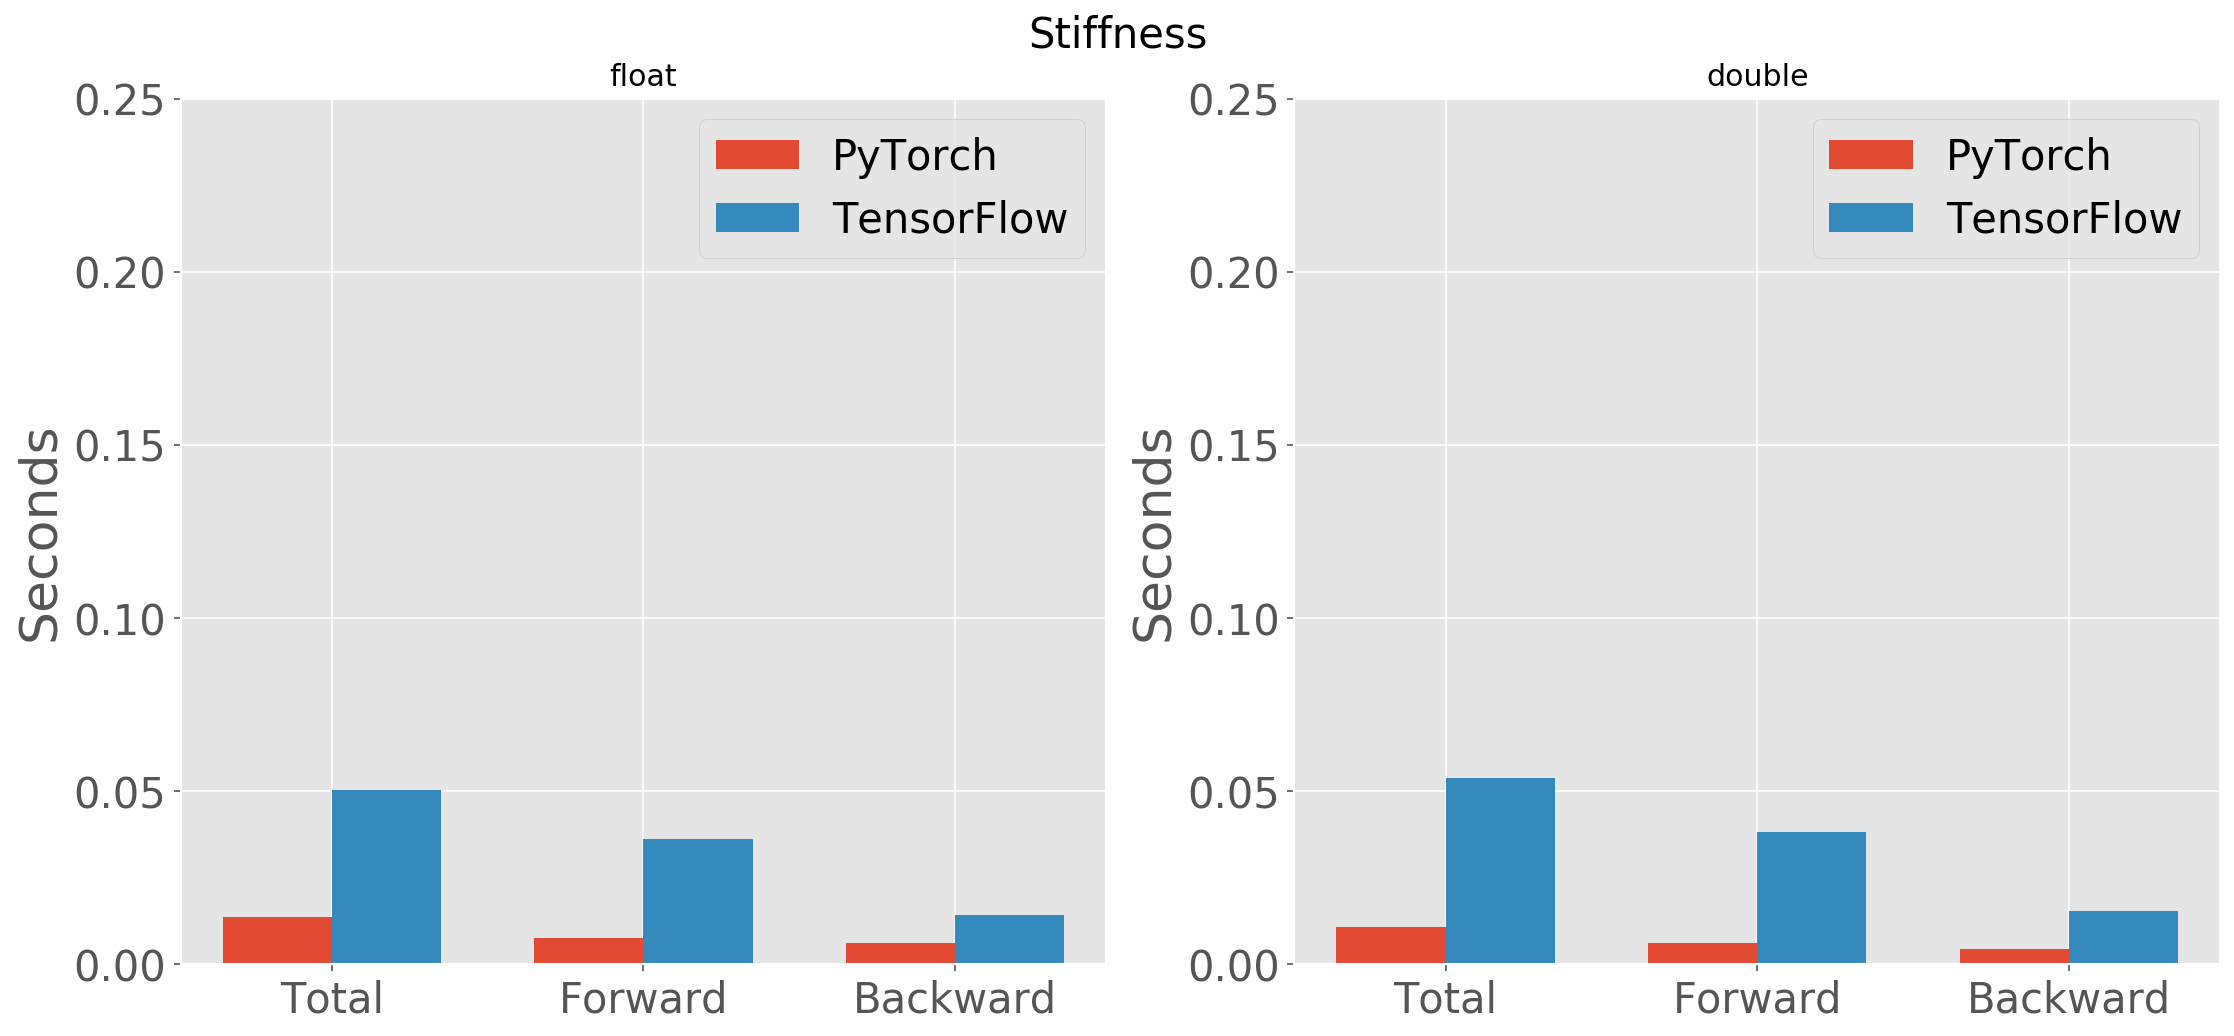

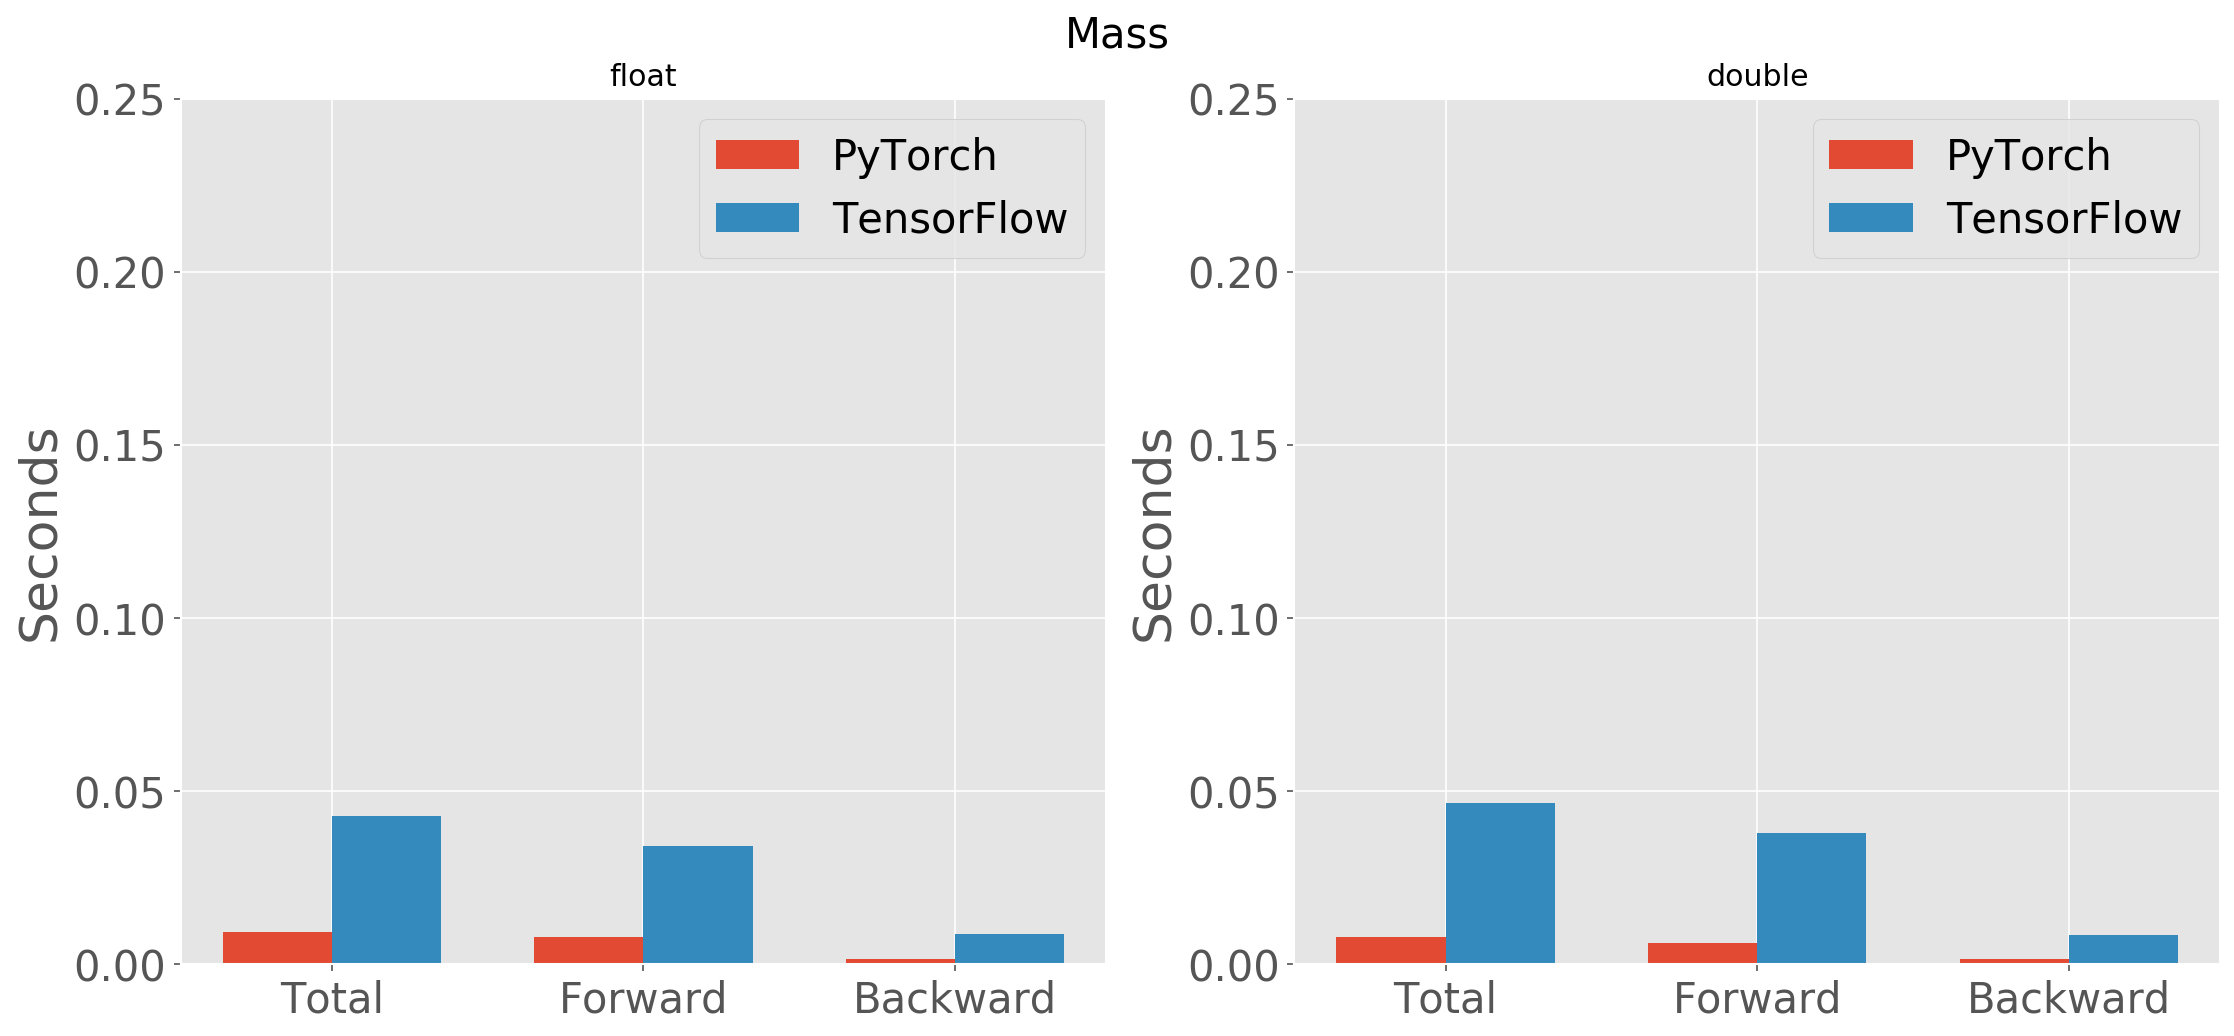

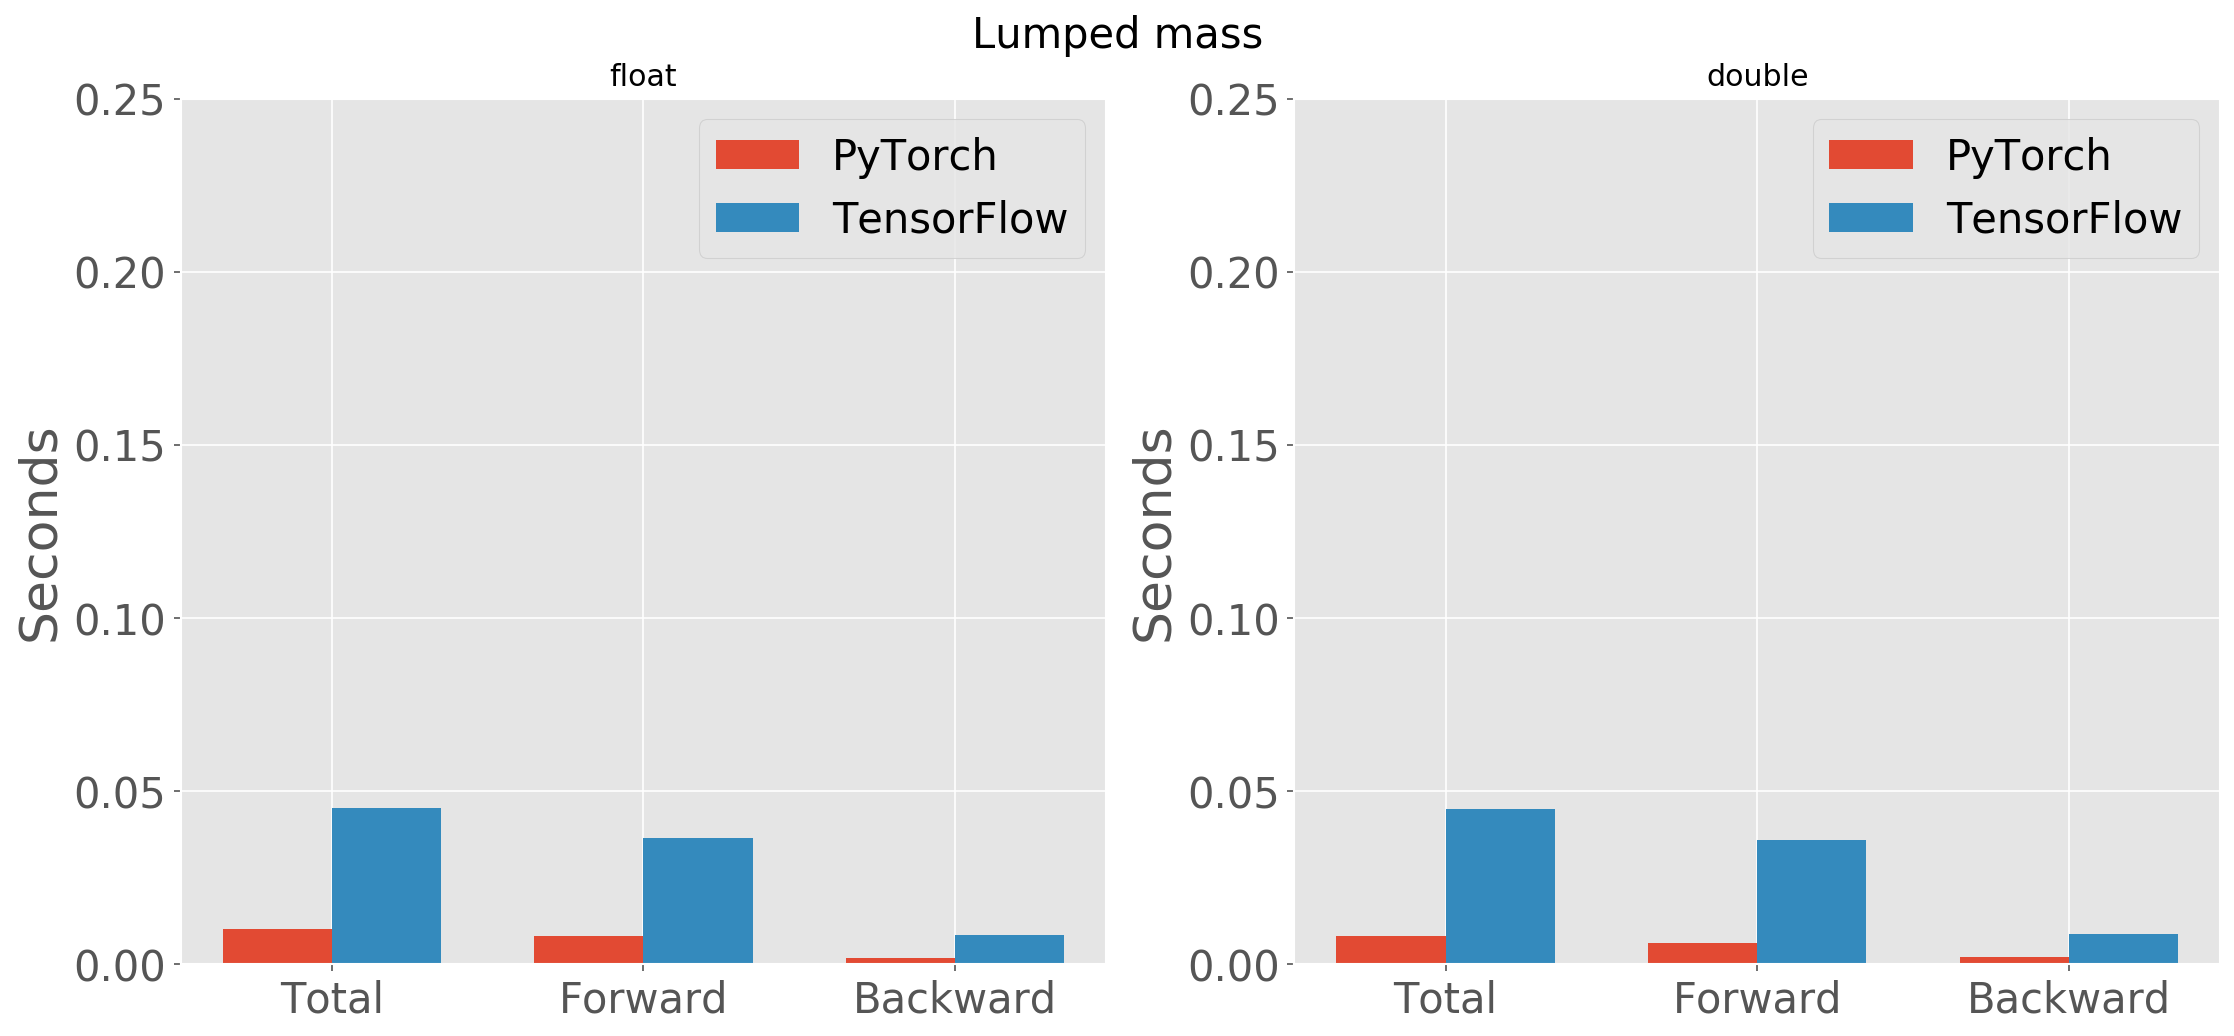

In [36]:
for p in ['float', 'double']:
    info, grad = benchmark_torch( lambda x, y: torch.sparse.sum(calc_LB_FEM_torch(x, y)[0]), get_pytorch_tensors(p), p, title='stiffness', info=info,verbose=False )
    info, grad = benchmark_torch( lambda x, y: torch.sparse.sum(calc_LB_FEM_torch(x, y)[1]), get_pytorch_tensors(p), p, title='mass', info=info,verbose=False)
    info, grad = benchmark_torch( lambda x, y: torch.sum(calc_LB_FEM_torch(x, y)[2]), get_pytorch_tensors(p), p, title='lumped mass', info=info,verbose=False)

for p in ['float', 'double']:
    info, _ = benchmark_tf(lambda x, y: tf.sparse.reduce_sum(calc_LB_FEM_tf(x, y)[0]), get_tensorflow_tensors(p), p, 'stiffness', info=info,verbose=False)
    info, _ = benchmark_tf(lambda x, y: tf.sparse.reduce_sum(calc_LB_FEM_tf(x, y)[1]), get_tensorflow_tensors(p), p, 'mass', info=info,verbose=False)
    info, _ = benchmark_tf(lambda x, y: tf.reduce_sum(calc_LB_FEM_tf(x, y)[2]), get_tensorflow_tensors(p), p, 'lumped mass', info=info,verbose=False)

o = display_benchmark(info, 'stiffness')
o = display_benchmark(info, 'mass')
o = display_benchmark(info, 'lumped mass')

# Cholesky decomposition

The gradient of the eigenvalue computation is known. It is not known how to compute the gradient on the generalized eigenvalue problem, where the gradient must backprop through two matrices.

It is possible to **reduce the generalized eigenvalue problem to a normal eigenvalue problem**, with the [cholesky decomposition](https://www.netlib.org/lapack/lug/node54.html).

___

Given the generalized eigenvalue problem $Az = \lambda Bz$ with:
- The cholesky factorization $B=LL^T$

The equivalent eigenvalue problem is $Cy = \lambda y$ with:
- $C=L^{-1}AL^{-T}$
- Recover the eigenvectors as $z = L^{-T}y$

---

The challenge is to perform the computation efficiently using sparse tensors.


- The cholesky decomposition of a diagonal matrix $X$ is simply $\sqrt X$ 

- $X^{-1} = \frac{1}{X}$ if $X$ is diagonal


- Given $X$ diagonal, $XS$ can be optimized exploiting the broadcasting as $diag(X)[:,\, None] \odot S$. In the same way $SX= S \odot diag(X)[None,\, :])$

---

Thus $C=L^{-1}AL^{-T}$ can be optimized as $diag(L^{-1})[:,\, None] \odot S \odot diag(L^{-1})[None,\, :]$


## Implementation

### PyTorch implementation

Main limitations:

- **Sparse tensors do not support broadcasting**, thus it's not possible to optimize the matrix multiplication
- It is **not possible to perform $sparse \cdot sparse \to sparse$**
- It is **not possible to perform $sparse \cdot dense \to sparse$**
- It is **not possible to perform $sparse \odot dense \to sparse$**

UPDATE 11/2019: [pytorch-sparse](https://github.com/rusty1s/pytorch_sparse) may be useful, it implements optimized $sparse \cdot dense \to dense$ and $sparse \cdot sparse \to dense$

The multiplication $sparse \odot dense \to sparse$ has been emulated eventhough **a dense matrix is involved**.

---

In particular it is possible to avoid the need of broadcasting with the following observation:

$$
X[:,\, None] \odot S \odot X[None,\, :]
=
S \odot (X[:,\, None] \odot X[None,\, :])
$$

However $(X[:,\, None] \odot X[None,\, :])$ **is a dense $n \times n$ matrix**.


In [37]:
def sparse_dense_mul(s, d):
    # implements point-wise product sparse * dense
    s = s.coalesce()
    i = s.indices()
    v = s.values()
    dv = d[i[0,:], i[1,:]]  # get values from relevant entries of dense matrix
    return torch.sparse.FloatTensor(i, v * dv, s.size()).coalesce()

def decomposition_torch(stiff, lumped_mass):
    # Cholesky decomposition for diagonal matrices
    lower = torch.sqrt(lumped_mass)

    # Compute inverse
    lower_inv = 1 / lower


    # todo1: when pytorch will support broadcastin on sparse tensor it will be enough:
    # C = lower_inv[None, :] * stiff * lower_inv[:, None]
    #
    # todo2: in alternative, use sparse @ stiff @ sparse when supported
    C = sparse_dense_mul(stiff, lower_inv[None, :] * lower_inv[:, None])  # <- INEFFICIENCY
    return C

### TensorFlow implementation

*Known limitations*:

-

In [38]:
def decomposition_tf(stiff, lumped):
    # Cholesky decomposition for diagonal matrices
    lower = tf.math.sqrt(lumped)

    # Compute inverse
    lower_inv = 1 / lower

    # lower^(-1) @ stiff @ lower^(-T)
    C = lower_inv[None, :] * stiff * lower_inv[:, None]

    return C

## Coherency

Ensure the PyTorch and TensorFlow computation in the forward pass are coherent.

In [39]:
def check_coherency2(precision):
    xtorch, ytorch = get_pytorch_tensors(precision)
    xtf, ytf = get_tensorflow_tensors(precision)

    atorch, _, ctorch = calc_LB_FEM_torch(xtorch, ytorch)
    dectorch = decomposition_torch(atorch, ctorch)
    
    atf, _, ctf = calc_LB_FEM_tf(xtf, ytf)
    dectf = decomposition_tf(atf, ctf)
    
    allclose(dectorch.cpu().detach().to_dense(), tf.sparse.to_dense(dectf), 'decomposition' )
    return dectorch, dectf

### Float precision

In [40]:
a, b = check_coherency2('float')

Equality check decomposition:	False	  
	Errore assoluto: max(abs( torch - tf )) = 1227488.0; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 0.0037514902651309967


### Double precision

In [41]:
a, b = check_coherency2('double')

Equality check decomposition:	True	  
	Errore assoluto: max(abs( torch - tf )) = 0.0035547614097595215; 
	Errore relativo: max(abs(torch - tf)) / max(abs(torch), 1e-10) = 1.0937084600453531e-11


## Benchmark

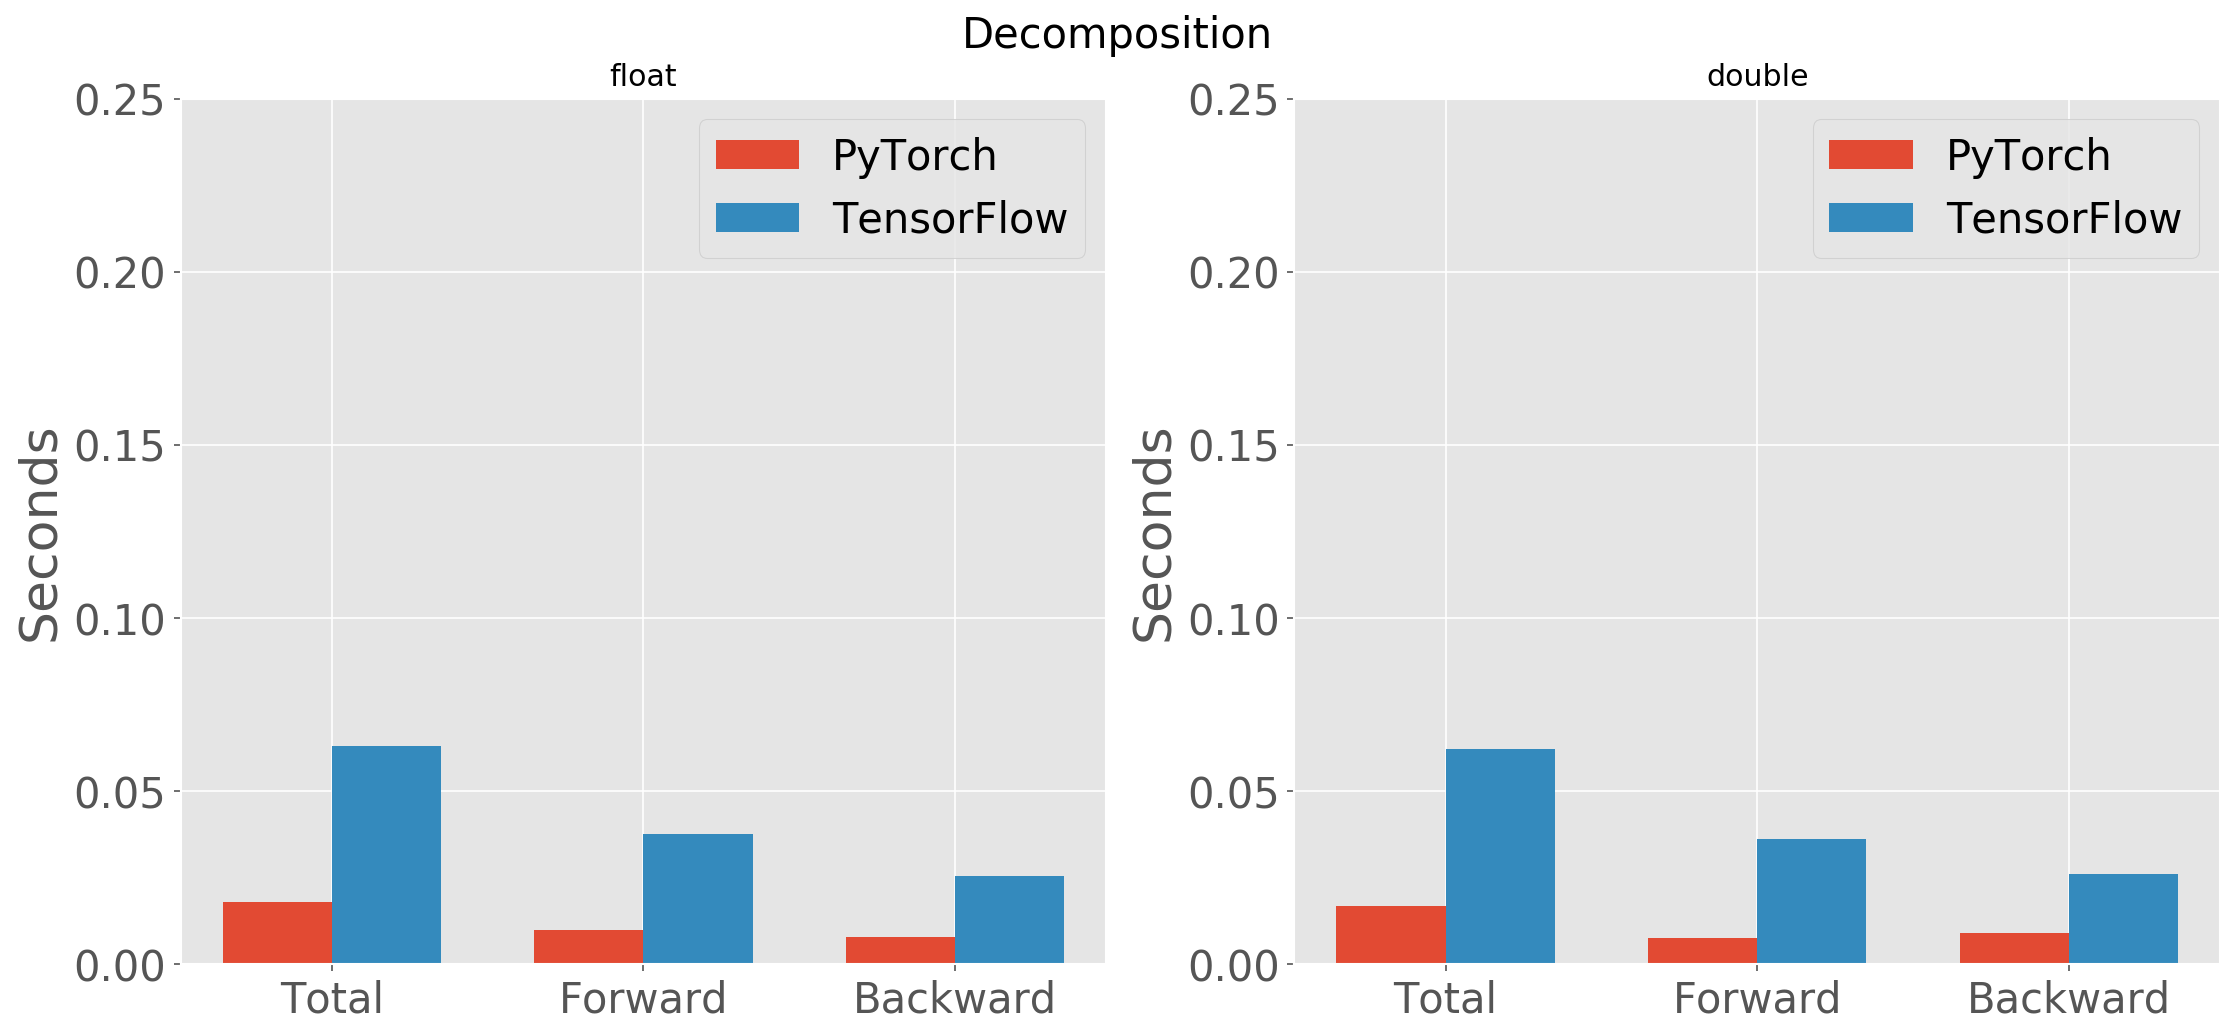

In [42]:
def fun(vertices, faces):
    stiff, _, lumped = calc_LB_FEM_torch(vertices, faces)
    out = decomposition_torch(stiff, lumped)
    return torch.sparse.sum(out)

for p in ['float', 'double']:
    info, grad = benchmark_torch(fun, get_pytorch_tensors(p), p, 'decomposition', info=info, verbose=False)

def fun(vertices, faces):
    stiff, _, lumped = calc_LB_FEM_tf(vertices, faces)
    out = decomposition_tf(stiff, lumped)
    return tf.sparse.reduce_sum(out)

for p in ['float', 'double']:
    info, grad = benchmark_tf(fun, get_tensorflow_tensors(p), p, 'decomposition', info, verbose=False)
    
o = display_benchmark(info, name='decomposition')

# Sparse k-eigensolver

The eigensolver available in PyTorch or TensorFlow do not support:

- Sparse tensors
- Computation of a subset of eigenvalues

## Implementation


*Known limitations*:

- Backend **solver works on CPU**, thus:
    - It is slow 
    - There is overhead in data download/upload

### PyTorch implementation

*Known limitations*:

- The **gradient is a dense $n \times n$ matrix** and must be converted to sparse manually before backpropagating it. It is not possible to directly compute sparse gradients due to the lack of sparse matrix operations that produce sparse matrices.
- Gather and indexing ops **do not return sparse gradients**. And in general many gradients are dense when they could be sparse. The API is WIP ([link](https://github.com/pytorch/pytorch/issues/9674)), it may be possible to improve this behaviour with some options on ops.

Thus there is a **slow backpropagation** due to the dense gradient.


*UPDATE 20/11*: Using the approach forced by tensorflow is faster. Convert the sparse tensor to dense before the eigensolver, and return a dense tensor.

In [43]:
import scipy.sparse as scisparse
from scipy.sparse import linalg as sla

class Eigsh_torch(torch.autograd.Function):
    # Reference issue
    # https://github.com/pytorch/pytorch/issues/24185

    @staticmethod
    def forward(ctx, A, values=None, indices=None, k=30, sigma=-1e-5, maxiter=None, tol=0 ):
        # Currently using scipy, on cpu, as backend
        # (torch.symeig computes all eigenvalues only on dense tensors)
        #
        # todo: check if CuPy will support eigsh:
        # https://docs-cupy.chainer.org/en/stable/reference/comparison.html?highlight=eigsh
        assert values is not None
        assert indices is not None
        
        device = A.device
        precision = A.dtype

        values = values.detach().cpu().numpy()
        indices = indices.detach().cpu().numpy()
                
        Ascipy = scisparse.coo_matrix((values, indices)).tocsc()

        e, phi = sla.eigsh(
            Ascipy,
            k,
            sigma=sigma)

        e, phi = (torch.tensor(e, dtype=precision, device=device, requires_grad=False),
                  torch.tensor(phi, dtype=precision, device=device, requires_grad=False))

        ctx.save_for_backward(phi)
        return e

    @staticmethod
    def backward(ctx, glambda):
        # Implementation reference:
        # https://github.com/pytorch/pytorch/blob/9228dd766af09017364bfaa7f88feacb7e89a154/tools/autograd/templates/Functions.cpp#L1701
        # https://people.maths.ox.ac.uk/gilesm/files/NA-08-01.pdf
        v, = ctx.saved_tensors
        device = glambda.device
        # v:                   [n, k]
        # glambda:             [k]
        # result:              [n, n]
        vt = v.transpose(-2, -1)
        
        # v @ diag(glambda) @ vt
        result = (v * glambda[None, :]) @ vt

        return result, None, None, None, None, None

### TensorFlow implementation

*Known limitations*:

- A function with a custom gradient must take a **dense tensor in input**. This forces the conversion between sparse to dense and back to sparse to use efficiently the scipy eigensolver.

Thus there is a **slow forward pass**, probably due to the dense tensor.

It is possible to pass the dense tensor togheter with the sparse tensor decomposed in values and indices, and perform the backpropagation only trhough the dense tensor.

---

The **backpropagation is much faster** due to the internal use of indexedslices tensors, a way to represent sparse gradients known to appear in some op (e.g. gather and indexing).

In [44]:
@tf.custom_gradient
def Eigsh_tf(C, values, indices, k=30, sigma=-1e-5):
    #Cannot take in input SparseTensors
    
    precision = C.dtype
    Ascipy = scisparse.coo_matrix((values.numpy(), tf.transpose(indices).numpy())).tocsc()

    e, phi = sla.eigsh(
        Ascipy,
        k,
        sigma=sigma)
    
    e, phi = (tf.convert_to_tensor(e, dtype=precision),
             tf.convert_to_tensor(phi, dtype=precision))
    
    def grad(glambda):
        vt = tf.transpose(phi)
        result = phi @ tf.linalg.tensor_diag(glambda) @ vt
        return result, None, None
    
    return e, grad

## Benchmark

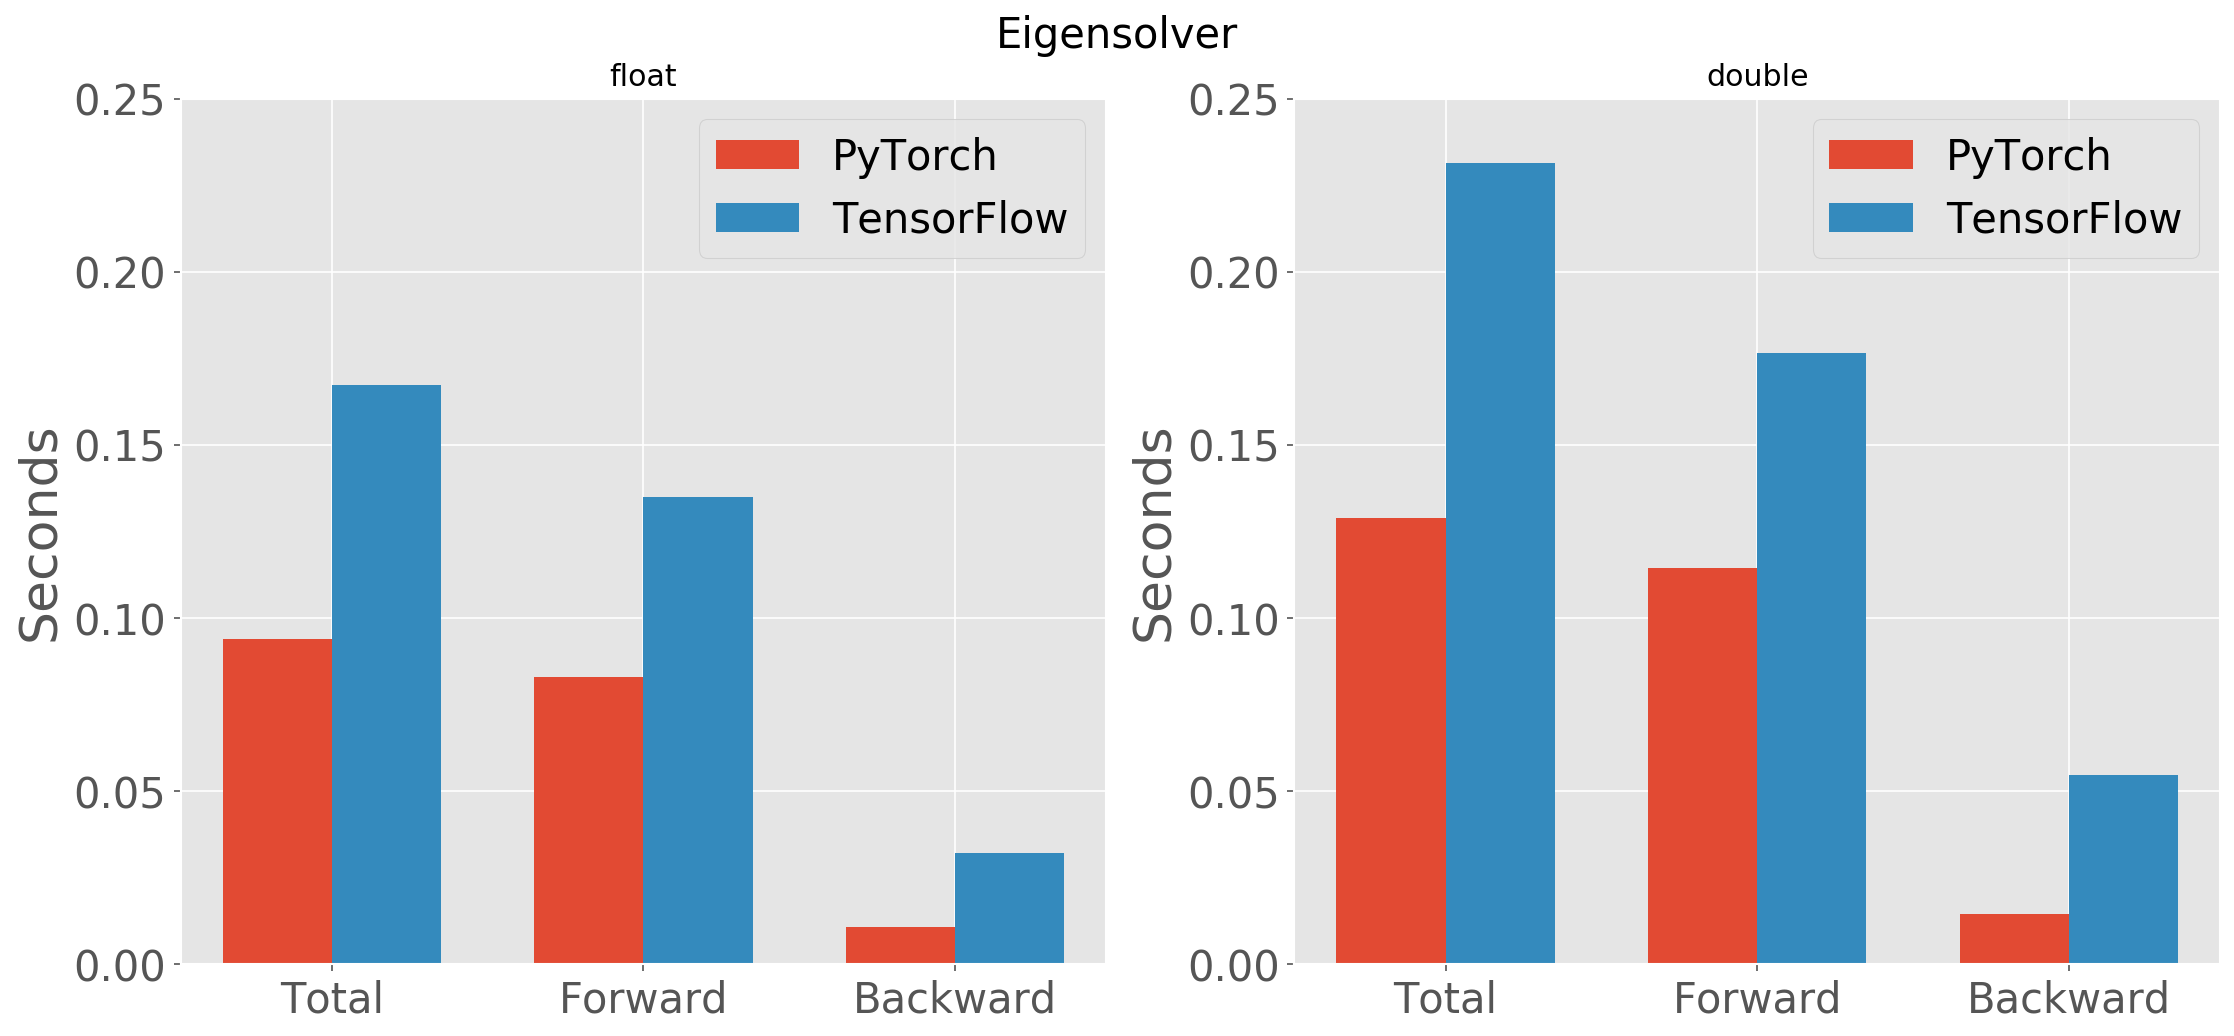

In [46]:
def fun(vertices, faces):
    stiff, _, lumped = calc_LB_FEM_torch(vertices, faces)
    C = decomposition_torch(stiff, lumped)
    e = Eigsh_torch.apply(C.to_dense(), C.values(), C.indices())
    return torch.sum(e)

for p in ['float', 'double']:
    info, grad = benchmark_torch(fun, get_pytorch_tensors(p), p, 'eigensolver', info, verbose=False)

def fun(vertices, faces):
    stiff, _, lumped = calc_LB_FEM_tf(vertices, faces)
    C = decomposition_tf(stiff, lumped)
    e = Eigsh_tf(tf.sparse.to_dense(C), C.values, C.indices)
    return tf.reduce_sum(e)

for p in ['float', 'double']:
    info, grad = benchmark_tf(fun, get_tensorflow_tensors(p), p, 'eigensolver', info,  verbose=False)
    
o = display_benchmark(info, 'eigensolver')

# Benchmark recap

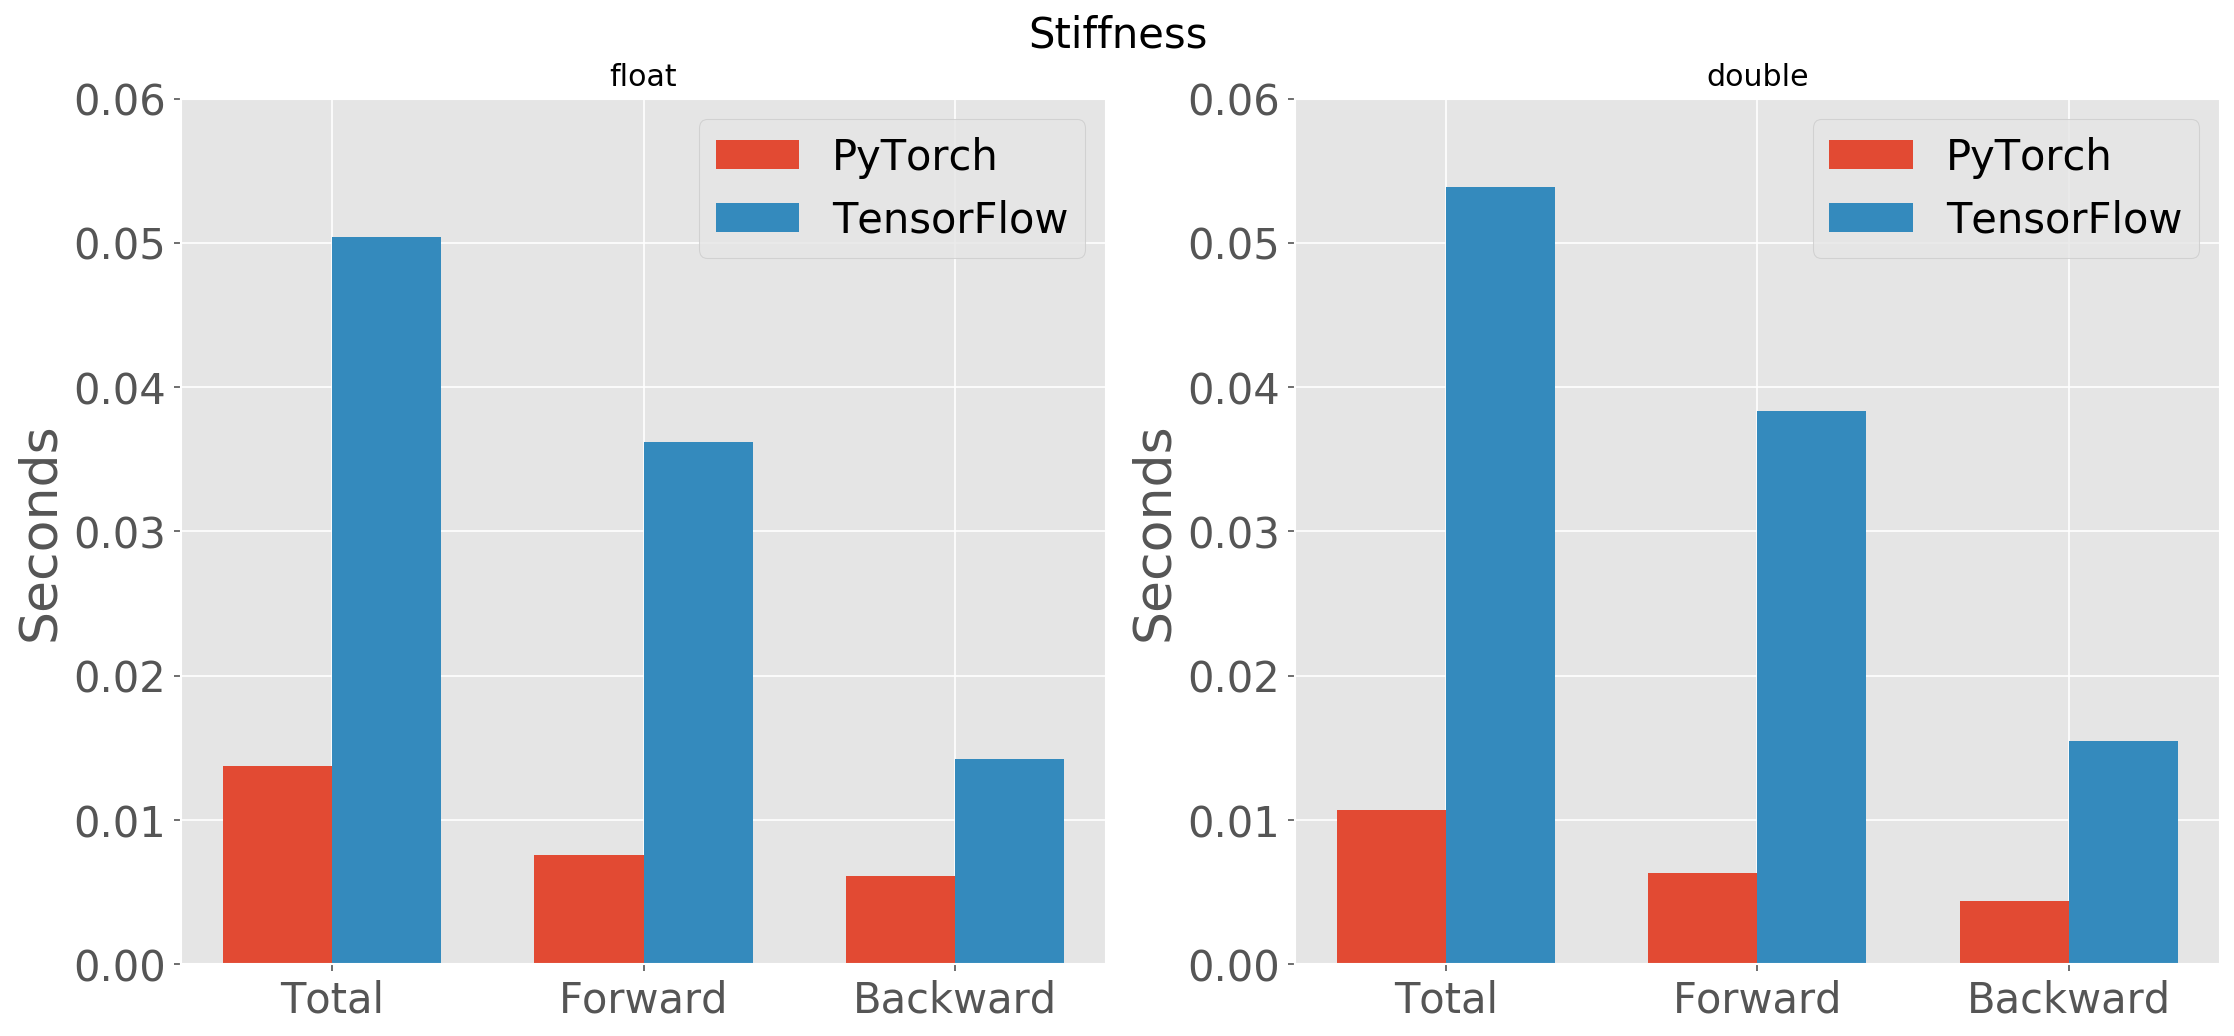

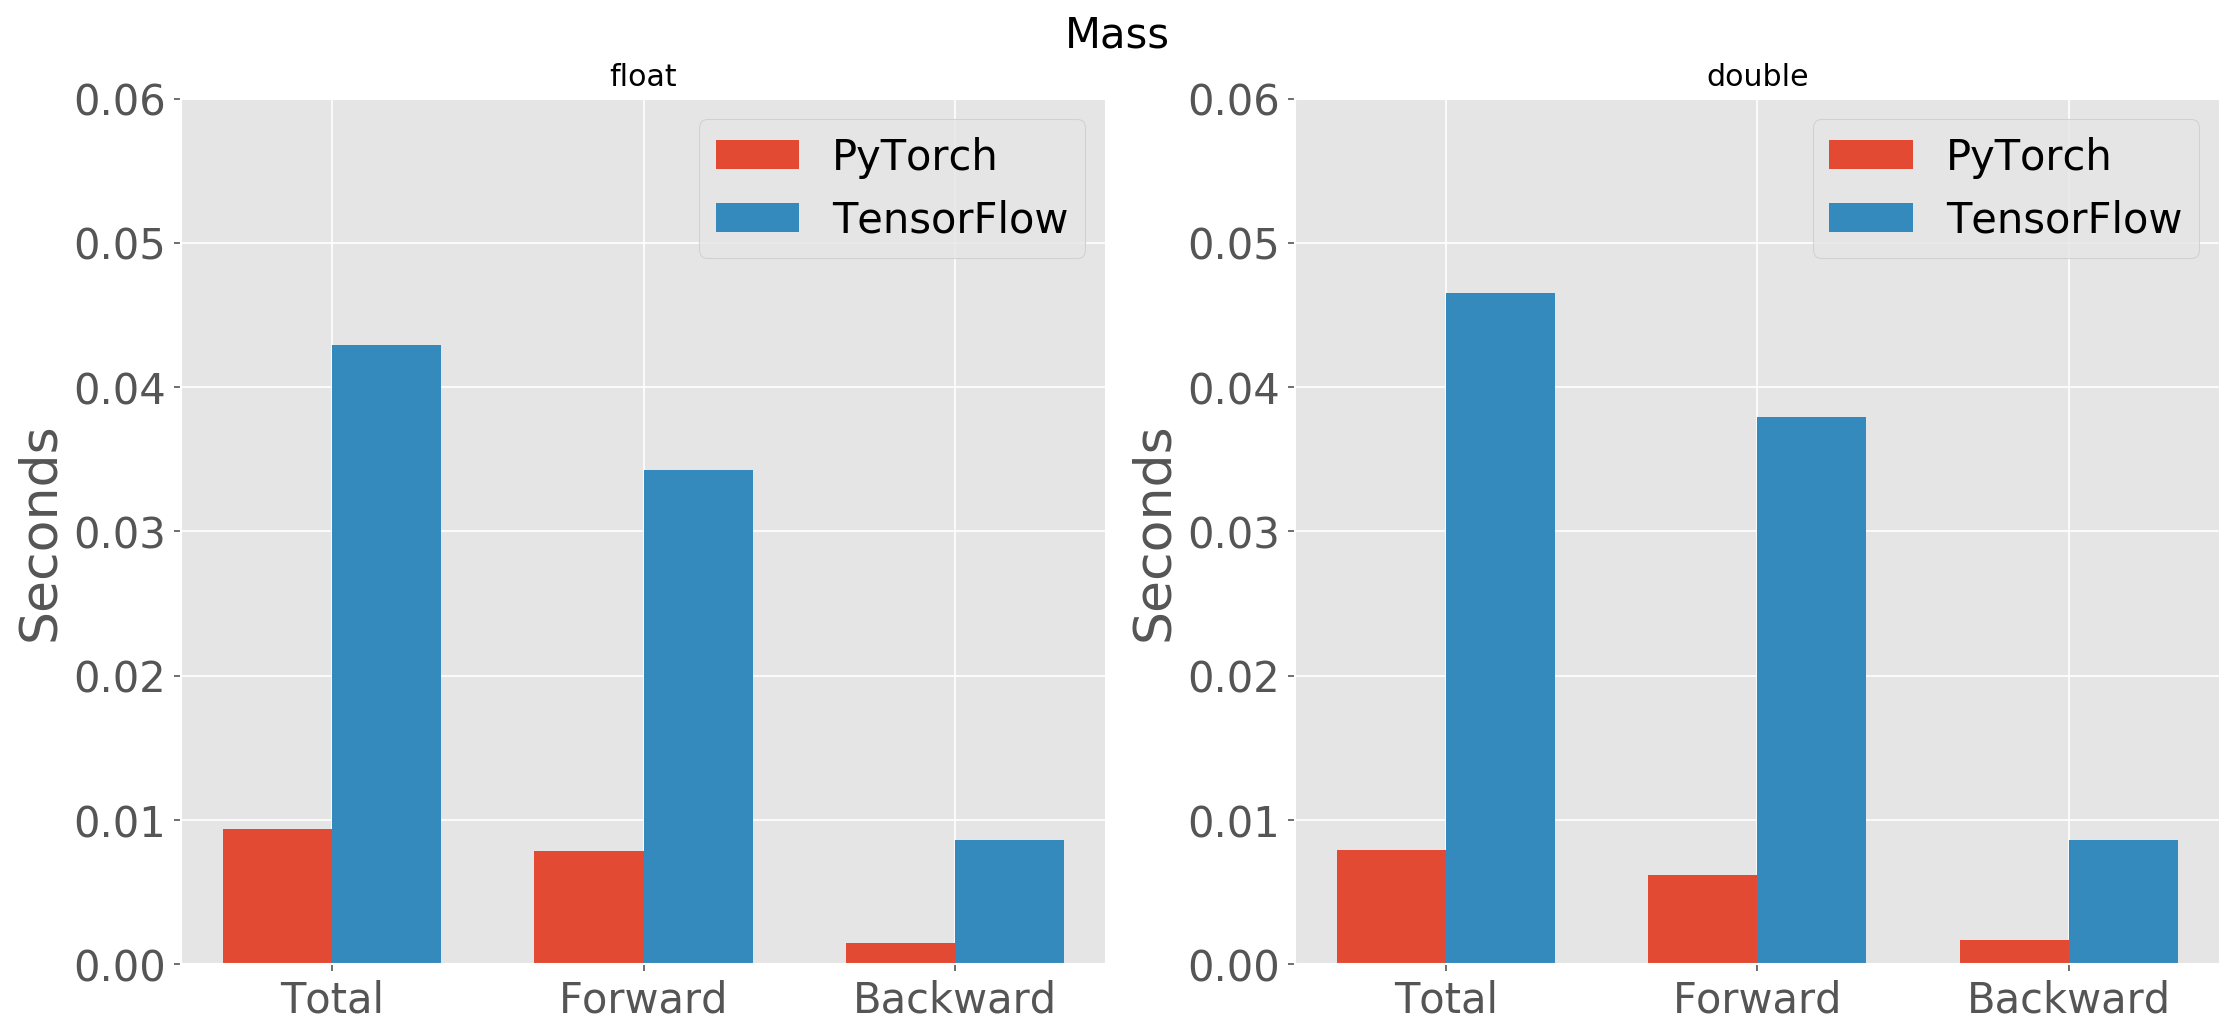

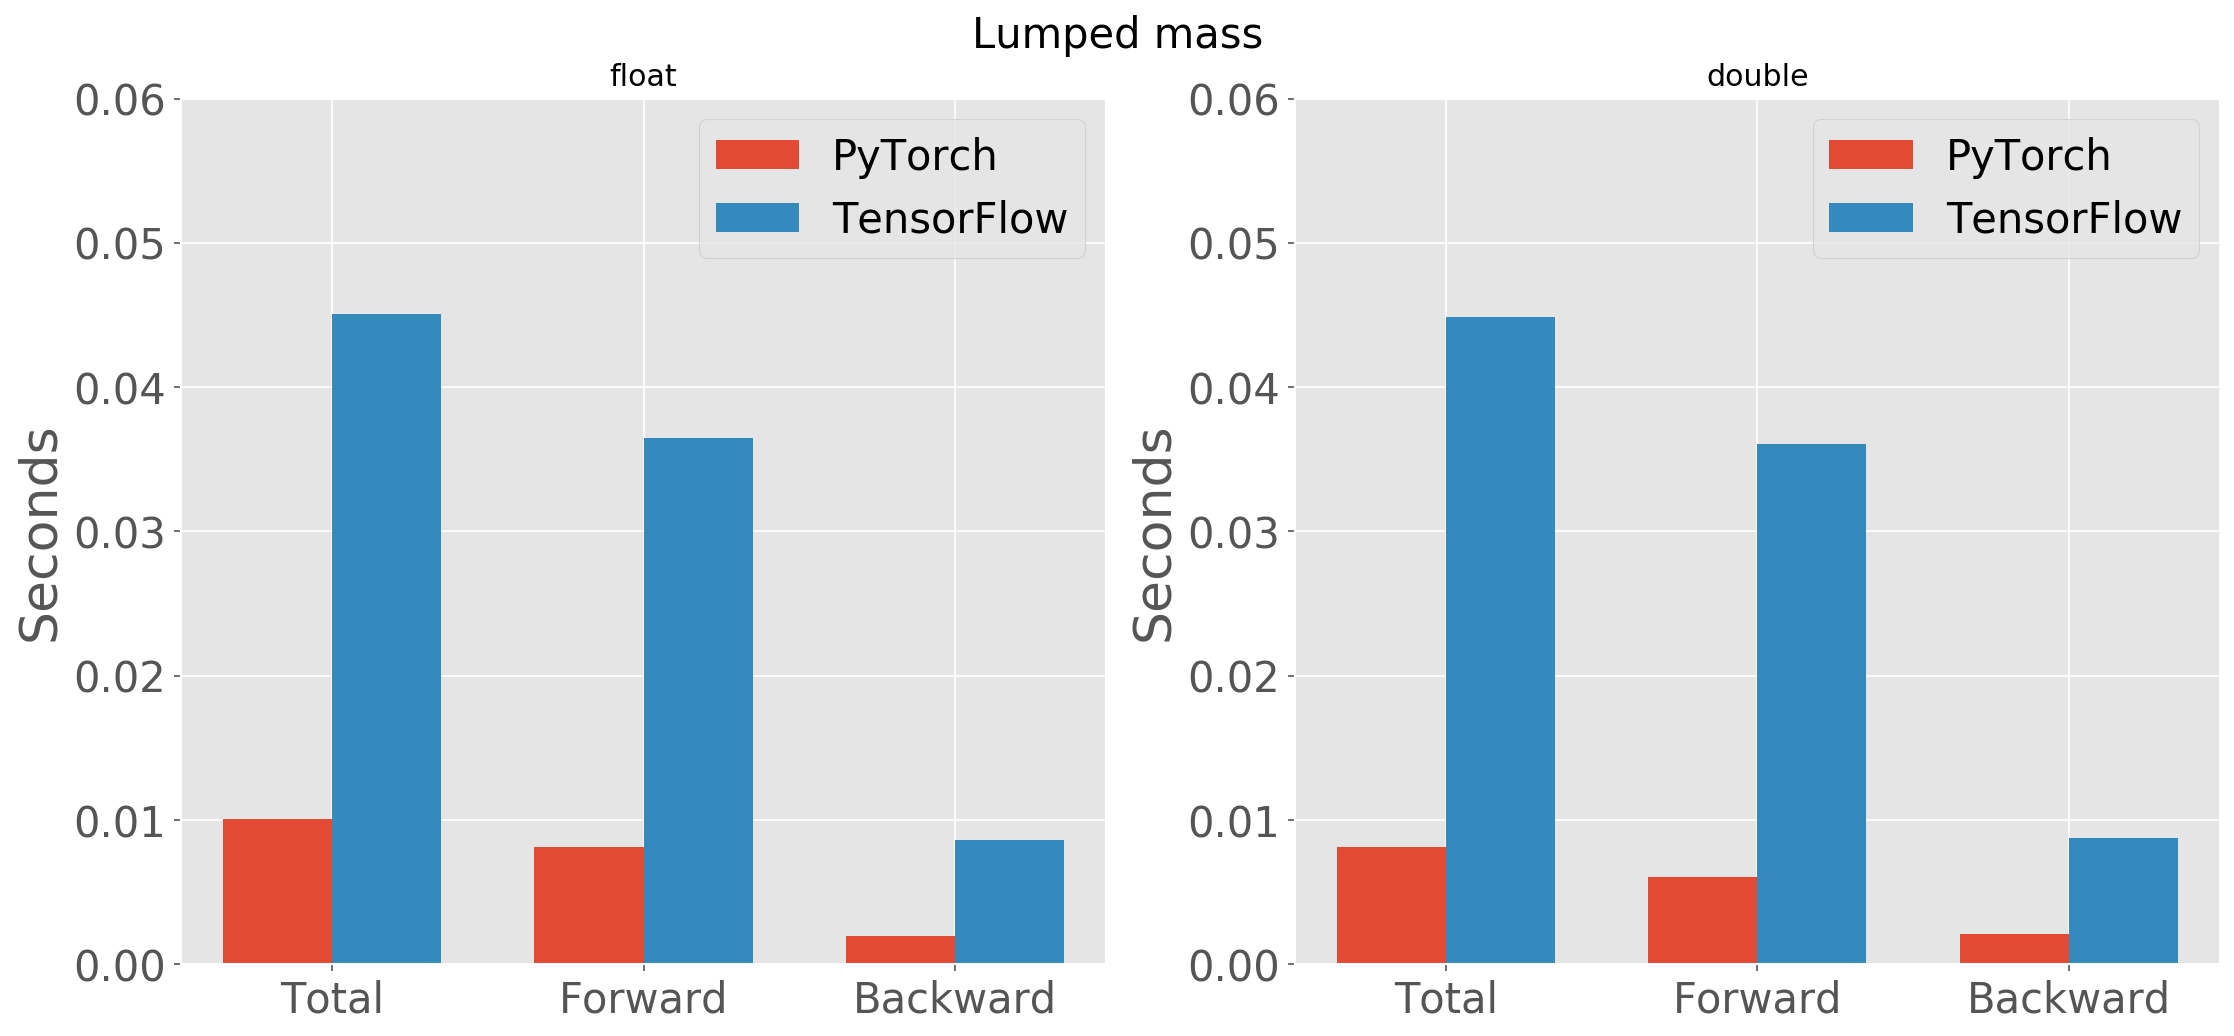

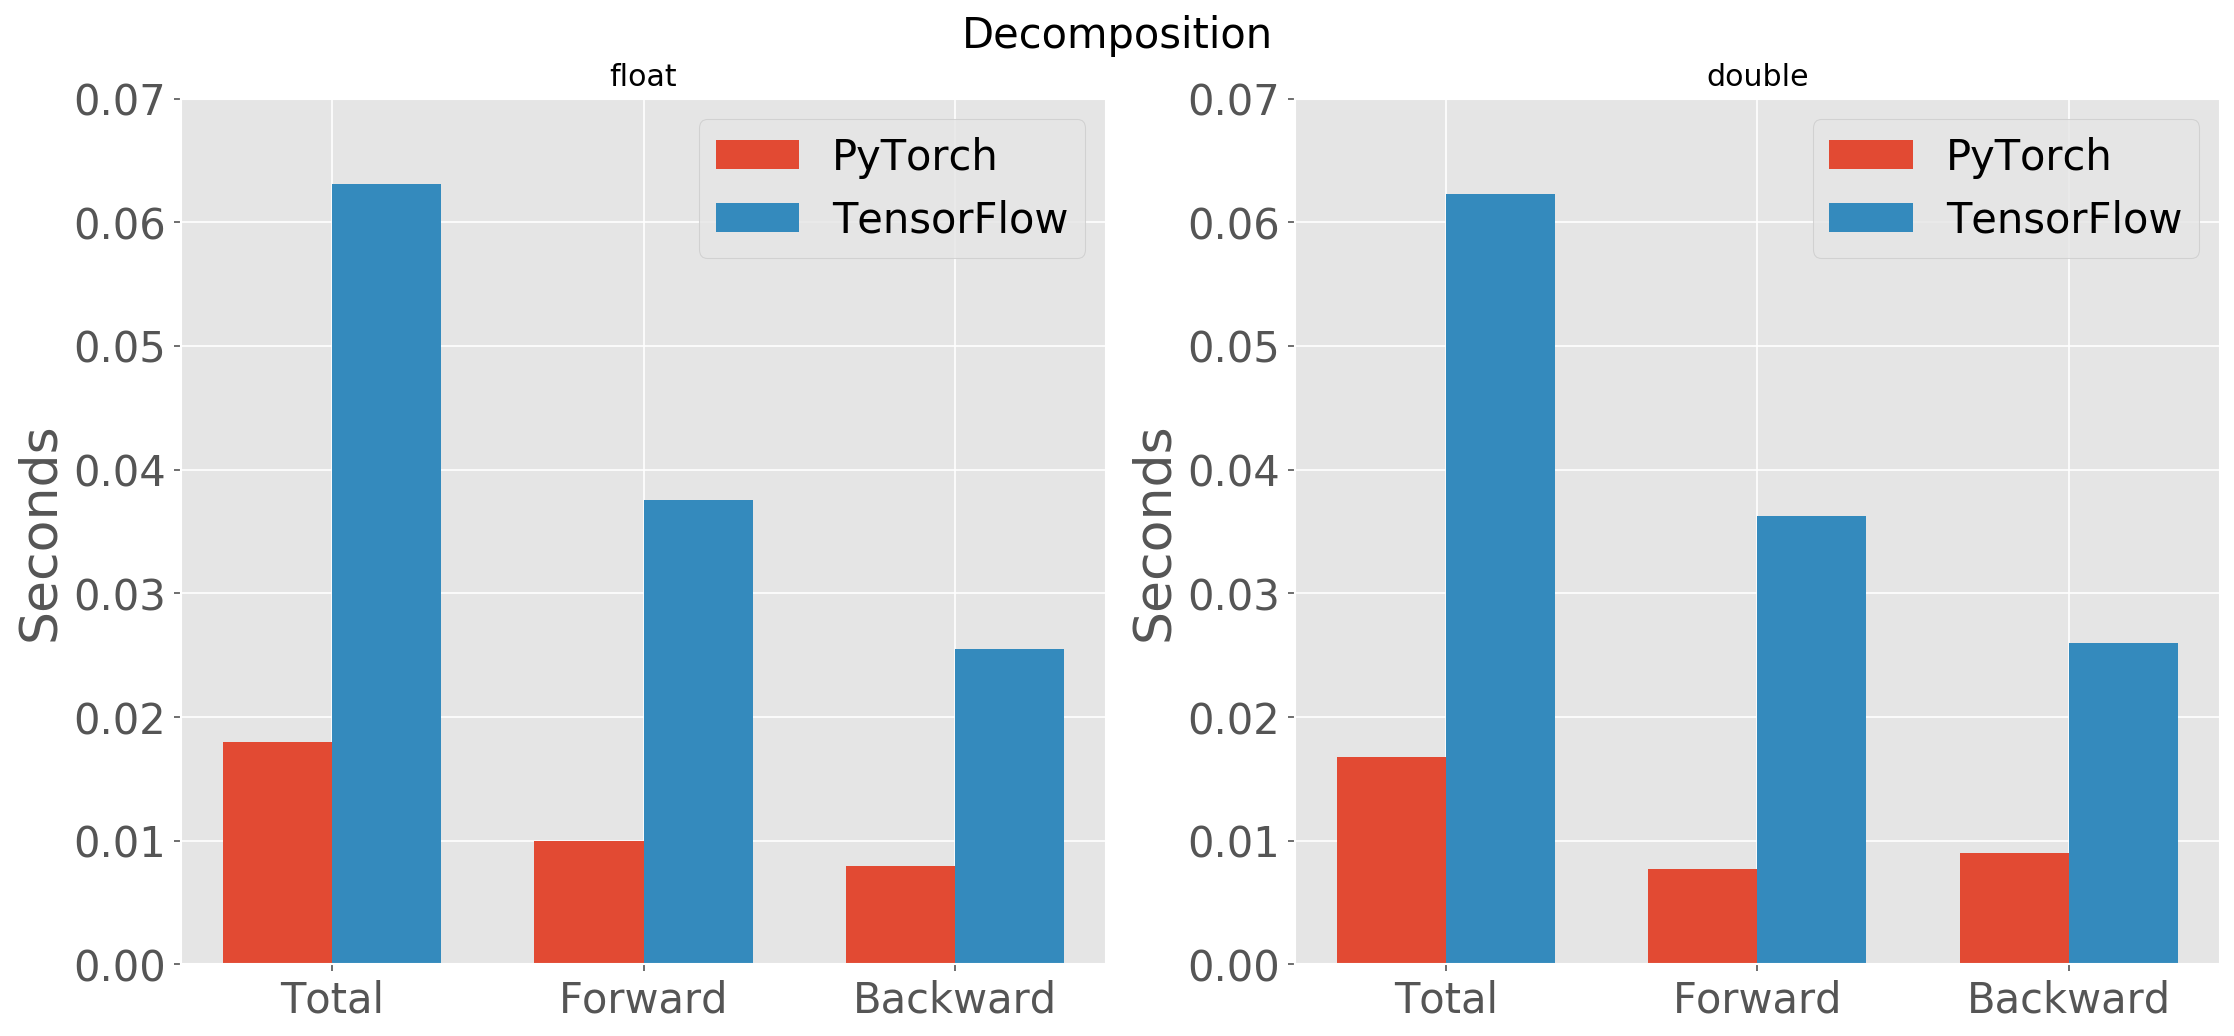

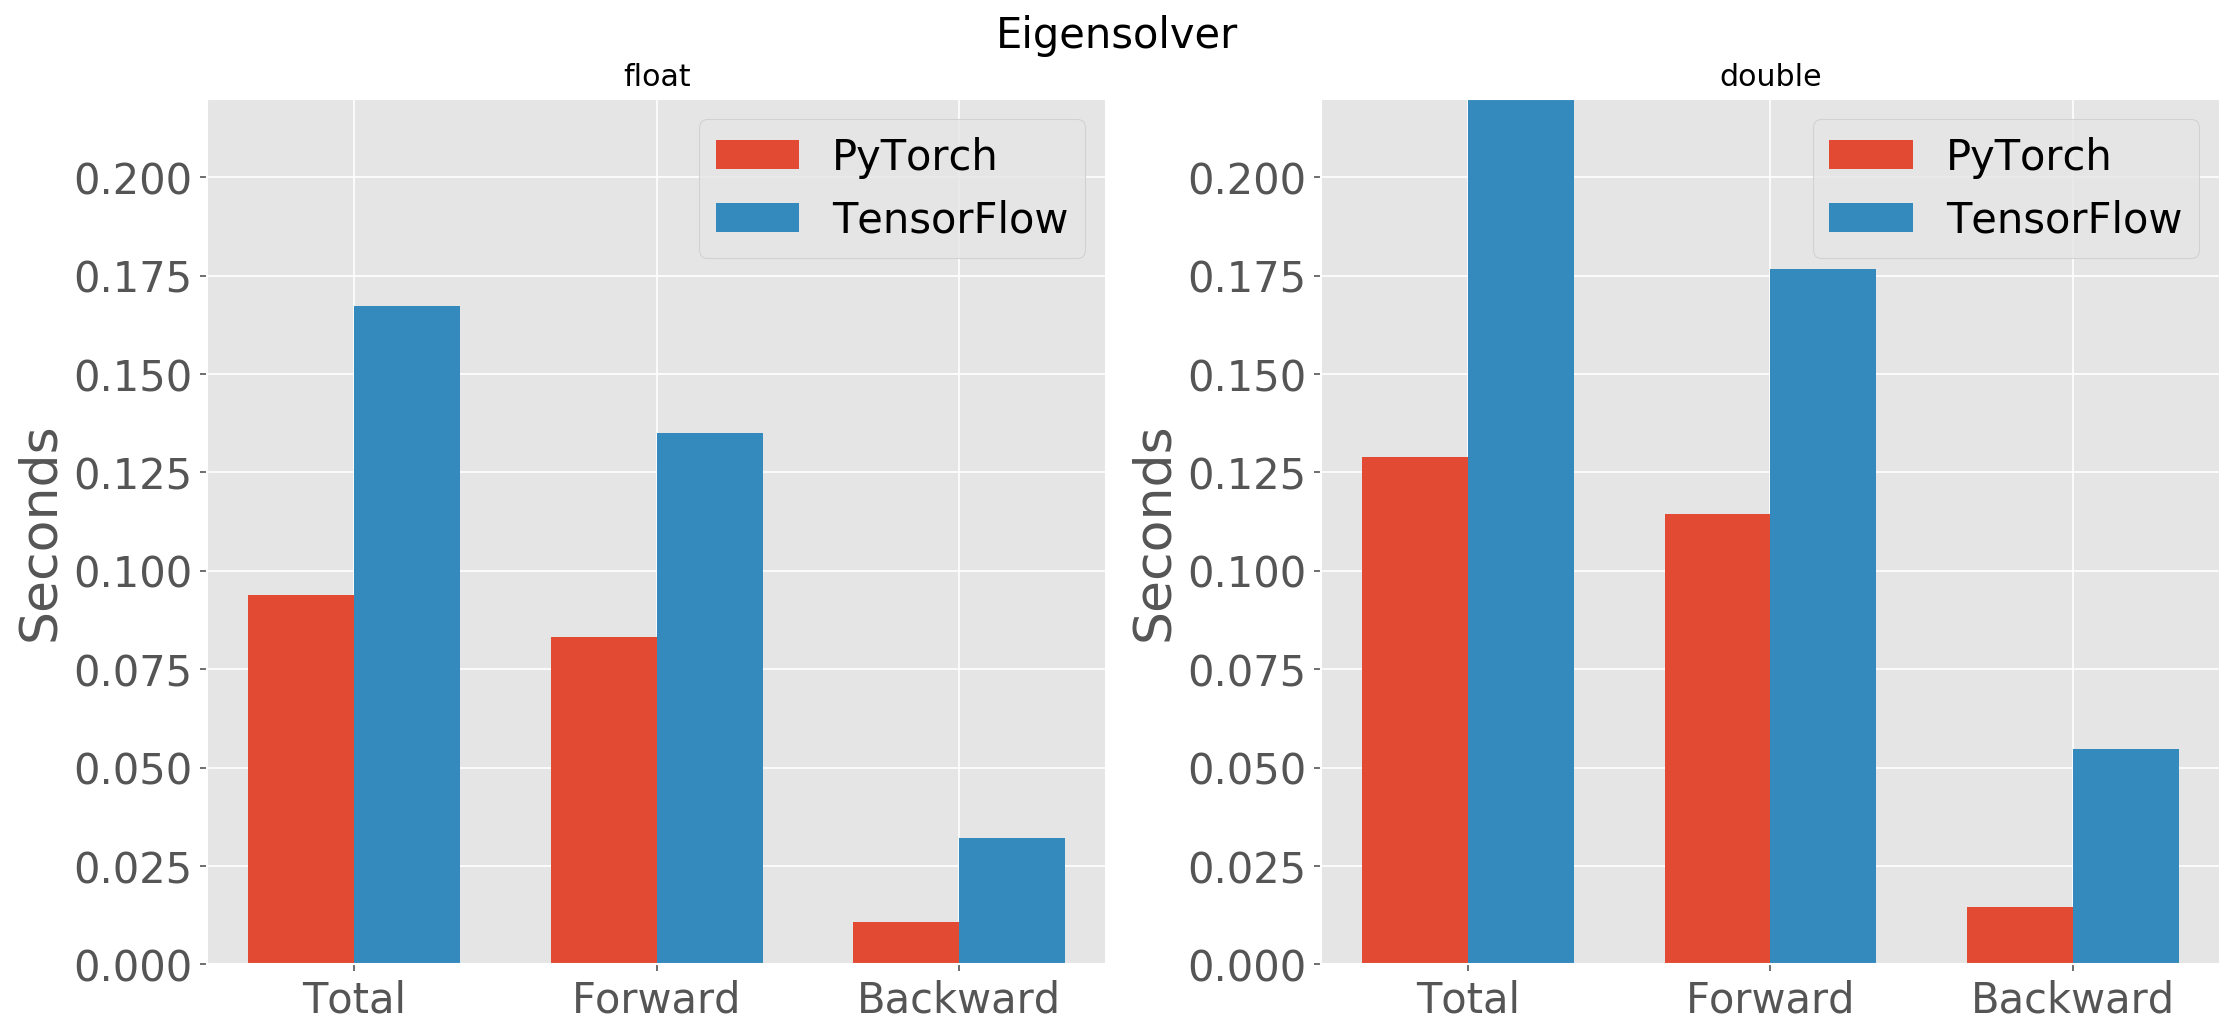

In [47]:
o = display_benchmark(info, 'stiffness', ylim=0.06)
o = display_benchmark(info, 'mass', ylim=0.06)
o = display_benchmark(info, 'lumped mass', ylim=0.06)
o = display_benchmark(info, name='decomposition', ylim=0.07)
o = display_benchmark(info, 'eigensolver', ylim=.22)